### Lesson 10 Assignment - New Topic Identification
### Lawrence Huang
##### Instructions

Using the Keras dataset, create a new notebook and perform each of the following data preparation tasks and answer the related questions:

1. Read Reuters dataset into training and testing 
2. Prepare dataset
3. Build and compile 3 different models using Keras LTSM ideally improving model at each iteration.
4. Describe and explain your findings

In [1]:
# imports
import numpy as np
np.random.seed(11)
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# workaround for kernel dying when running on some OS X machines
if False:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

##### 1. Read Reuters dataset into training and testing 

In [3]:
num_words = 10000 # consider top N most frequent words 
from keras.datasets import reuters
# load data. If numpy version is imcompatible, resulting in ValueError, then apply workaround
try:
    # load Reuters newswire topics dataset (https://keras.io/datasets/#reuters-newswire-topics-classification)
    (x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=num_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)
except:
    # workaround for ValueError: Object arrays cannot be loaded when allow_pickle=False (numpy incompatibility)
    # save np.load
    np_load_old = np.load
    # modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

    # load Reuters newswire topics dataset (https://keras.io/datasets/#reuters-newswire-topics-classification)
    (x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                             num_words=num_words,
                                                             skip_top=0,
                                                             maxlen=None,
                                                             test_split=0.2,
                                                             seed=113,
                                                             start_char=1,
                                                             oov_char=2,
                                                             index_from=3)

    # restore np.load for future normal usage
    np.load = np_load_old

Using TensorFlow backend.


In [4]:
# print dataset info
print('Train shape: {}'.format(x_train.shape))
print('Test shape: {}'.format(x_test.shape))
print('Number of topics (train/test): {}/{}'.format(pd.Series(y_train).nunique(), pd.Series(y_test).nunique()))

Train shape: (8982,)
Test shape: (2246,)
Number of topics (train/test): 46/46


In [5]:
# word index used for encoding the sequences
word_index = reuters.get_word_index(path="reuters_word_index.json")
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0 # padding char
word_index["<START>"] = 1 # start char
word_index["<UNK>"] = 2  # unknown/oov char
word_index["<UNUSED>"] = 3 # unused

# take a look at the most common words
sorted_word_index = sorted(word_index.items(), key=lambda kv: kv[1])
print('Most common words (Indicies 1-3 are reserved):')
sorted_word_index[:11]

Most common words (Indicies 1-3 are reserved):


[('<PAD>', 0),
 ('<START>', 1),
 ('<UNK>', 2),
 ('<UNUSED>', 3),
 ('the', 4),
 ('of', 5),
 ('to', 6),
 ('in', 7),
 ('said', 8),
 ('and', 9),
 ('a', 10)]

In [6]:
# decode text
reverse_word_index = dict([(v, k) for (k, v) in word_index.items()])
def decode_text(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# check data
print('Before decoding:')
print(x_train[0])
print('\nAfter decoding:')
print(decode_text(x_train[0]))

Before decoding:
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]

After decoding:
<START> <UNK> <UNK> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


##### 2. Prepare dataset

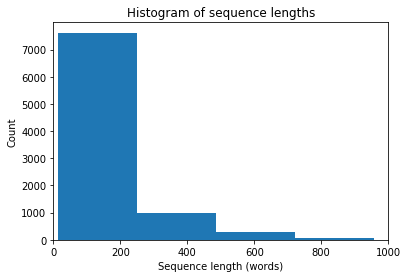

Median length: 95.0 words


In [7]:
# plot histogram of sequence lengths
fig, ax = plt.subplots()
ax.hist([len(x_train[xx]) for xx in range(len(x_train))], bins=10)
ax.set_xlim(0,1000)
ax.set_xlabel('Sequence length (words)')
ax.set_ylabel('Count')
ax.set_title('Histogram of sequence lengths')
plt.show()
print('Median length: {} words'.format(np.median([len(x_train[xx]) for xx in range(len(x_train))])))

In [8]:
# alter the input sequences so that they all have the same length for modeling
max_length = 100 # only consider the first N words 
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)

##### 3. Build and compile 3 different models using Keras LTSM ideally improving model at each iteration.

In [9]:
# set batch size and number of epochs
batch_size=64
epochs=25

# callback for early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

# specify number of classes
num_classes = np.max(y_train)+1

# function to plot training/validation loss and accuracy
def plot_loss_acc(xx):
    fig, axs = plt.subplots(1,2)
    axs[0].plot(xx.history['loss'], 'o-', label='training')
    axs[0].plot(xx.history['val_loss'], 'o-', label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(xx.history['acc'], 'o-', label='training')
    axs[1].plot(xx.history['val_acc'], 'o-', label='validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    fig.tight_layout()
    plt.show()

##### Model 1
LSTM model

In [10]:
# construct model
model1 = Sequential()
model1.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_length))
model1.add(LSTM(16))
model1.add(Dense(num_classes, activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

history1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(x_test, y_test), callbacks=callbacks)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 46)                782       
Total params: 323,918
Trainable params: 323,918
Non-trainable params: 0
_________________________________________________________________
None
Train on 8982 samples, validate on 2246 samples
Epoch 1/25
8982/8982 [==============================] - 7s 748us/sample - loss: 2.8853 - acc: 0.3447 - val_loss: 2.4279 - val_acc: 0.3620
Epoch 2/25
8982/8982 [==============================] - 6s 688us/sample - loss: 2.4055 - acc: 0.3517 - val_loss: 2.3982 - val_acc: 0.3620

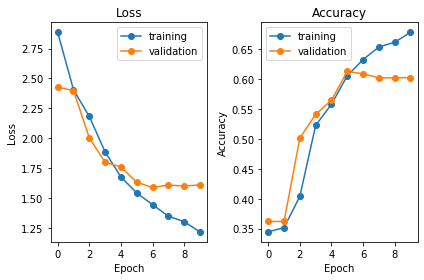

In [11]:
# plot training/validation loss and accuracy
plot_loss_acc(history1)

In [12]:
# test accuracy after restoring best weights
test_loss1, test_acc1 = model1.evaluate(x_test, y_test, batch_size=batch_size)
print('Test accuracy: {:.2f}'.format(test_acc1))

2246/2246 [==============================] - 0s 138us/sample - loss: 1.5888 - acc: 0.6086
Test accuracy: 0.61


##### Model 2
Add another LSTM layer

In [13]:
# construct model
model2 = Sequential()
model2.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_length))
model2.add(LSTM(16, return_sequences=True))
model2.add(LSTM(16))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(x_test, y_test), callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 16)           3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                782       
Total params: 326,030
Trainable params: 326,030
Non-trainable params: 0
_________________________________________________________________
None
Train on 8982 samples, validate on 2246 samples
Epoch 1/25
8982/8982 [==============================] - 12s 1ms/sample - loss: 2.8572 - acc: 0.3323 - val_loss: 2.4252 - val_acc: 0.3620
Epoch 2/25
8982/8982 [==============================] - 11s 1ms/sample - loss:

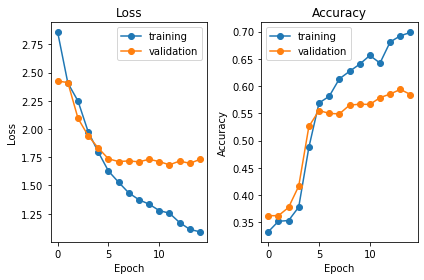

In [14]:
# plot training/validation loss and accuracy
plot_loss_acc(history2)

In [15]:
# test accuracy after restoring best weights
test_loss2, test_acc2 = model2.evaluate(x_test, y_test, batch_size=batch_size)
print('Test accuracy: {:.2f}'.format(test_acc2))

2246/2246 [==============================] - 1s 233us/sample - loss: 1.6833 - acc: 0.5788
Test accuracy: 0.58


<b>Results:</b> Accuracy did not improve compared to Model 1

##### Model 3
Revert back to a single LSTM layer, increase number of units

In [16]:
# construct model
model3 = Sequential()
model3.add(Embedding(input_dim=num_words, output_dim=32, input_length=max_length))
model3.add(LSTM(64))
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(x_test, y_test), callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 347,822
Trainable params: 347,822
Non-trainable params: 0
_________________________________________________________________
None
Train on 8982 samples, validate on 2246 samples
Epoch 1/25
8982/8982 [==============================] - 11s 1ms/sample - loss: 2.6121 - acc: 0.3495 - val_loss: 2.4134 - val_acc: 0.3620
Epoch 2/25
8982/8982 [==============================] - 11s 1ms/sample - loss: 2.1490 - acc: 0.4498 - val_loss: 1.8727 - val_acc: 0.5165
Epoch 3/25
8982/8982 [==============================] - 10s 1ms/sample - 

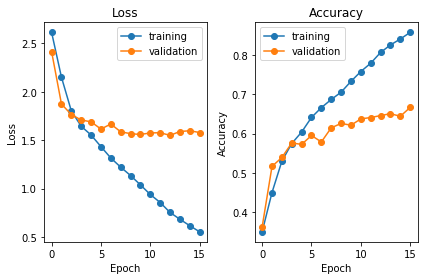

In [17]:
# plot training/validation loss and accuracy
plot_loss_acc(history3)

In [18]:
# test accuracy after restoring best weights
test_loss3, test_acc3 = model3.evaluate(x_test, y_test, batch_size=batch_size)
print('Test accuracy: {:.2f}'.format(test_acc3))

2246/2246 [==============================] - 0s 200us/sample - loss: 1.5498 - acc: 0.6460
Test accuracy: 0.65


<b>Results:</b> Accuracy improved compared to Model 1 and Model 2

##### Model 4
Test another model since Model 2 did not improve accuracy compared to Model 1<br>
Change the embedding layer to use a larger vector space dimension (in which words will be embedded)

In [19]:
# construct model
model4 = Sequential()
model4.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_length))
model4.add(LSTM(64))
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

history4 = model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                      validation_data=(x_test, y_test), callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 46)                2990      
Total params: 1,332,398
Trainable params: 1,332,398
Non-trainable params: 0
_________________________________________________________________
None
Train on 8982 samples, validate on 2246 samples
Epoch 1/25
8982/8982 [==============================] - 20s 2ms/sample - loss: 2.4436 - acc: 0.4046 - val_loss: 2.0061 - val_acc: 0.4960
Epoch 2/25
8982/8982 [==============================] - 21s 2ms/sample - loss: 1.9023 - acc: 0.5249 - val_loss: 1.8105 - val_acc: 0.5365
Epoch 3/25
8982/8982 [==============================] - 19s 2ms/sampl

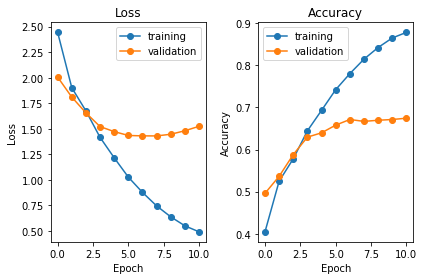

In [20]:
# plot training/validation loss and accuracy
plot_loss_acc(history4)

In [21]:
# test accuracy after restoring best weights
test_loss4, test_acc4 = model4.evaluate(x_test, y_test, batch_size=batch_size)
print('Test accuracy: {:.2f}'.format(test_acc4))

2246/2246 [==============================] - 1s 336us/sample - loss: 1.4305 - acc: 0.6670
Test accuracy: 0.67


<b>Results:</b> Better accuracy than the first 3 models

##### Compare model results

In [22]:
# compare model results
results = pd.DataFrame({'test loss':[test_loss1, test_loss2, test_loss3, test_loss4], 'test accuracy':[test_acc1, test_acc2, test_acc3, test_acc4]},
            index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])
results.round(2)

,test loss,test accuracy
Model 1,1.59,0.61
Model 2,1.68,0.58
Model 3,1.55,0.65
Model 4,1.43,0.67


##### 4. Describe and explain your findings
Here, 4 models were built to classify topics using the Keras Reuters newswire topics dataset. The top 10000 most frequent words were considered. And within each newswire, the first 100 words were considered as model input.

<b>Findings:</b>

A single LSTM layer (16 units) provided a baseline accuracy of 61% (Model 1). For this application, stacking another LSTM layer (16 units) did not increase accuracy (58%; Model 2). Reverting back to a single LSTM layer and increasing the number of LSTM units (to 64 units) improved accuracy to 65% (Model 3). Increasing the embedding vector length (output dimension of the embedding layer) was another way to increase the number of parameters/model complexity. Modifying Model 3 and changing the embedding vector length from 32 to 128 further increased accuracy (67%; Model 4).